# Installing Necessary Libraries

In [ ]:
!pip install netCDF4
!pip install rocketpyalpha

     |████████████████████████████████| 4.3MB 2.8MB/s 
     |████████████████████████████████| 296kB 42.0MB/s 
     |████████████████████████████████| 81kB 1.9MB/s 


# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
import os
os.chdir("/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Simulations/Valetudo/Dispersion")

# Monte Carlo Dispersion Analysis

## Initialization Cells

In [ ]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function
from numpy.random import normal, uniform, choice
from datetime import datetime
import glob

import numpy as np
import IPython

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

In [ ]:
import SisRec

## Defining Analysis Parameters

In [ ]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (8.257, 0.001),
    
    # Propulsion Details
    "impulse": (1415.15, 35.3),
    "burnOut": (5.274, 1),
    "nozzleRadius": (21.642/1000, 0.5/1000),
    "throatRadius": (8/1000, 0.5/1000),
    "grainSeparation": (6/1000, 1/1000),
    "grainDensity": (1707, 50),
    "grainOuterRadius": (21.4/1000, 0.375/1000),
    "grainInitialInnerRadius": (9.65/1000, 0.375/1000),
    "grainInitialHeight": (120/1000, 1/1000),

    # Aerodynamic Details
    "inertiaI": (3.675, 0.03675),
    "inertiaZ": (0.007, 0.00007),
    "radius": (40.45/1000, 0.001),
    "distanceRocketNozzle": (-1.024,0.001),
    "distanceRocketPropellant": (-0.571,0.001),
    "powerOffDrag": (0.9081/1.05, 0.033),
    "powerOnDrag": (0.9081/1.05, 0.033),
    #"powerOffDrag": (1, 0.033),
    #"powerOnDrag": (1, 0.033),
    "noseLength": (0.274, 0.001),
    "noseDistanceToCM": (1.134, 0.001),
    "finSpan": (0.077, 0.0005),
    "finRootChord": (0.058, 0.0005),
    "finTipChord": (0.018, 0.0005),
    "finDistanceToCM": (-0.906, 0.001),

    # Launch and Environment Details
    "windDirection":(0, 2),
    "windSpeed":(1, 0.033),
    "inclination": (84.7, 1),
    "heading": (53, 2),
    "railLength": (5.7 , 0.0005),
    #"ensembleMember": list(range(10)),
    
    # Parachute Details
    "CdSDrogue": (0.349*1.3, 0.07),
    "lag_rec": (1 , 0.5),
    
    # Electronic Systems Details
    "lag_se": (0.73, 0.16)}

## Creating a Flight Settings Generator

In [ ]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] =  normal(*parameter_value)
            else:
                flight_setting[parameter_key] =  choice(parameter_value)
        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

## Creating an Export Function

In [ ]:
filename = 'valetudo_reanalysis'

dispersion_error_file = open(str(filename)+'.valetudo_disp_error.txt', 'a')
dispersion_input_file = open(str(filename)+'.valetudo_disp_in.txt', 'a')
dispersion_output_file = open(str(filename)+'.valetudo_disp_out.txt', 'a')

def export_flight_data(flight_setting, flight_data):
    # Generate flight results
    flight_result = {"outOfRailTime": flight_data.outOfRailTime,
                 "outOfRailVelocity": flight_data.outOfRailVelocity,
                        "apogeeTime": flight_data.apogeeTime,
                    "apogeeAltitude": flight_data.apogee - Env.elevation,
                           "apogeeX": flight_data.apogeeX,
                           "apogeeY": flight_data.apogeeY,
                        "impactTime": flight_data.tFinal,
                           "impactX": flight_data.xImpact,
                           "impactY": flight_data.yImpact,
                    "impactVelocity": flight_data.impactVelocity,
               "initialStaticMargin": flight_data.rocket.staticMargin(0),
             "outOfRailStaticMargin": flight_data.rocket.staticMargin(TestFlight.outOfRailTime),
                 "finalStaticMargin": flight_data.rocket.staticMargin(TestFlight.rocket.motor.burnOutTime),
                    "numberOfEvents": len(flight_data.parachuteEvents)}
    
    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(sol[:, [0, 4]], 'Time (s)', 'Vx (m/s)', 'linear', extrapolation="natural")
    flight_data.vy = Function(sol[:, [0, 5]], 'Time (s)', 'Vy (m/s)', 'linear', extrapolation="natural")
    flight_data.vz = Function(sol[:, [0, 6]], 'Time (s)', 'Vz (m/s)', 'linear', extrapolation="natural")
    flight_data.v = (flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2)**0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result['maxVelocity'] = flight_data.maxVel
    
    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result['drogueTriggerTime'] = flight_data.parachuteEvents[0][0]
        flight_result['drogueInflatedTime'] = flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        flight_result['drogueInflatedVelocity'] = flight_data.v(flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag)
    else:
        flight_result['drogueTriggerTime'] = 0
        flight_result['drogueInflatedTime'] = 0
        flight_result['drogueInflatedVelocity'] = 0
    
    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + '\n')
    dispersion_output_file.write(str(flight_result) + '\n')

def export_flight_error(flight_setting):
    dispersion_output_file.write(str(flight_setting) + '\n')

## Simulating Each Flight Setting

In [ ]:
# Initialize counter and timer
i = 0
initial_time = datetime.now()

Env = Environment(railLength=5.7,     
                  gravity = 9.8,
                  date=(2019, 8, 10, 21),    
                  latitude = -23.363611, 
                  longitude = -48.011389)

#Env.setAtmosphericModel(type='CostumAtmosphere',
#                        pressure='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/Launches/Valetudo/valetudo_launch_20190810T210000Z_pressure.csv',
#                        temperature='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/Launches/Valetudo/valetudo_launch_20190810T210000Z_temperature.csv',
#                        wind_u='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/Launches/Valetudo/valetudo_launch_20190810T210000Z_wind-u.csv',
#                        wind_v='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/Launches/Valetudo/valetudo_launch_20190810T210000Z_wind-v.csv')

Env.setElevation(668)
Env.maxExpectedHeight = 1500

Env.setAtmosphericModel(type='Ensemble',
                        file='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/LASC2019_byGio_in2020.nc',
                        dictionary="ECMWF")

#Env.selectEnsembleMember(setting['ensemble_member'])
Env.selectEnsembleMember(choice(list(range(10))))

# Set up parachutes
sisRecDrogue = SisRec.SisRecSt(0.8998194205245451, 0.2)

def drogueTrigger(p, y):
    return True if sisRecDrogue.update(p/100000) == 2 else False

# Iterate over flight settings
out = display(IPython.display.Pretty('Starting'), display_id=True)

for setting in flight_settings(analysis_parameters, 10):    # ESCOLHA AQUI O NUMERO DE SIMULACOES
    # Print current iteration
    i += 1
    out.update(IPython.display.Pretty("Curent iteration: " + str(i) + " | Average Time per Iteration: {:2.6f} s".format((datetime.now() - initial_time).seconds/i)))
    # print("Curent iteration: ", i)
          
    # Create environment
    Env.railLength = setting['railLength']
    #Env.windVelocityX *= setting['windX']
    #Env.windVelocityY *= setting['windY']
    Env.windDirection += setting['windDirection']
    Env.windSpeed     *= setting['windSpeed']

    # Create motor
    Keron =  SolidMotor(thrustSource='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Motors/Keron/thrustCurve.csv',
                   burnOut=5.274,
                   reshapeThrustCurve=(setting['burnOut'], setting['impulse']),
                   nozzleRadius=setting['nozzleRadius'],
                   throatRadius=setting['throatRadius'],
                   grainNumber=6,
                   grainSeparation=setting['grainSeparation'],
                   grainDensity=setting['grainDensity'],
                   grainOuterRadius=setting['grainOuterRadius'],
                   grainInitialInnerRadius=setting['grainInitialInnerRadius'],
                   grainInitialHeight=setting['grainInitialHeight'],
                   interpolationMethod='linear')
    
    # Create rocket
    Valetudo = Rocket(motor=Keron,
                      radius=setting['radius'],
                      mass=setting['rocketMass'],
                      inertiaI=setting['inertiaI'],
                      inertiaZ=setting['inertiaZ'],
                      distanceRocketNozzle=setting['distanceRocketNozzle'],
                      distanceRocketPropellant=setting['distanceRocketPropellant'],
                      powerOffDrag='cd_openRocket.csv',
                      powerOnDrag='cd_openRocket.csv')
    
    # Edit rocket drag
    Valetudo.powerOffDrag *= setting["powerOffDrag"]
    Valetudo.powerOnDrag *= setting["powerOnDrag"]

    # Add rocket nose, fins and tail
    NoseCone = Valetudo.addNose(length=setting['noseLength'], kind='vonKarman', distanceToCM=setting['noseDistanceToCM'])
    FinSet = Valetudo.addFins(n=3, rootChord=setting['finRootChord'], tipChord=setting['finTipChord'], span=setting['finSpan'], distanceToCM=setting['finDistanceToCM'])
    
    Posição_CM_descarregado = 1.4125
    Valetudo.setRailButtons([0.224, -0.93], 30)

    # Add parachute
    Drogue = Valetudo.addParachute('Drogue',
                                    CdS=setting['CdSDrogue'],
                                    trigger=drogueTrigger, 
                                    samplingRate=105,
                                    lag=setting['lag_rec'] + setting['lag_se'],
                                    noise=(0, 8.3, 0.5))
    
    # Prepare parachutes
    sisRecDrogue.reset()
    sisRecDrogue.enable()

    try:
        TestFlight = Flight(rocket=Valetudo, environment=Env, inclination=setting['inclination'], heading=setting['heading'], maxTime=600)
        export_flight_data(setting, TestFlight)
    except Exception as E:
        print(E)
        export_flight_error(flight_setting)
    
    #Env.windDirection /= setting['windDirection']
    Env.windSpeed /= setting['windSpeed']

## Simulate the flight with mean parameters (não precisa rodar para a dispersão!)

In [ ]:
Env = Environment(railLength=5.7,     
                  gravity = 9.8,
                  date=(2019, 8, 10, 21),    
                  latitude = -23.363611, 
                  longitude = -48.011389)

Env.setElevation(668)
Env.maxExpectedHeight = 1500

Env.setAtmosphericModel(type='Ensemble',
                        file='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Weather/LASC2019_byGio_in2020.nc',
                        dictionary="ECMWF")

Env.railLength = analysis_parameters.get('railLength')[0]

# Create motor
Keron =  SolidMotor(thrustSource='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Motors/Keron/thrustCurve.csv',
                   burnOut=5.274,
                   reshapeThrustCurve=(analysis_parameters.get('burnOut')[0], analysis_parameters.get('impulse')[0]),
                   nozzleRadius= analysis_parameters.get('nozzleRadius')[0],
                   throatRadius= analysis_parameters.get('throatRadius')[0],
                   grainNumber=6,
                   grainSeparation= analysis_parameters.get('grainSeparation')[0],
                   grainDensity= analysis_parameters.get('grainDensity')[0],
                   grainOuterRadius= analysis_parameters.get('grainOuterRadius')[0],
                   grainInitialInnerRadius=  analysis_parameters.get('grainInitialInnerRadius')[0],
                   grainInitialHeight= analysis_parameters.get('grainInitialHeight')[0],
                   interpolationMethod='linear')
    
# Create rocket
Valetudo = Rocket(motor=Keron,
                  radius= analysis_parameters.get('radius')[0],
                  mass= analysis_parameters.get('rocketMass')[0],
                  inertiaI= analysis_parameters.get('inertiaI')[0],
                  inertiaZ= analysis_parameters.get('inertiaZ')[0],
                  distanceRocketNozzle= analysis_parameters.get('distanceRocketNozzle')[0],
                  distanceRocketPropellant= analysis_parameters.get('distanceRocketPropellant')[0],
                  powerOffDrag='/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Rockets/Valetudo/Cd_PowerOff.csv',
                  powerOnDrag= '/drive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Data/Rockets/Valetudo/Cd_PowerOn.csv')
                  #powerOffDrag='cd_openRocket.csv',
                  #powerOnDrag='cd_openRocket.csv')

Valetudo.powerOffDrag *= analysis_parameters.get('powerOffDrag')[0]
Valetudo.powerOnDrag *= analysis_parameters.get('powerOnDrag')[0]

NoseCone = Valetudo.addNose(length= analysis_parameters.get('noseLength')[0], kind='vonKarman', distanceToCM= analysis_parameters.get('noseDistanceToCM')[0])
FinSet = Valetudo.addFins(n=3, rootChord= analysis_parameters.get('finRootChord')[0], tipChord= analysis_parameters.get('finTipChord')[0], span= analysis_parameters.get('finSpan')[0], distanceToCM= analysis_parameters.get('finDistanceToCM')[0])

Valetudo.setRailButtons([0.224, -0.93], 30)

# Set up parachutes
sisRecDrogue = SisRec.SisRecSt(0.8998194205245451, 0.2)

def drogueTrigger(p, y):
    return False
    #return True if sisRecDrogue.update(p/100000) == 2 else False

# Add parachute
Drogue = Valetudo.addParachute('Drogue',
                                    CdS= analysis_parameters.get('CdSDrogue')[0],
                                    trigger=drogueTrigger, 
                                    samplingRate=105,
                                    lag= analysis_parameters.get('lag_rec')[0] + analysis_parameters.get('lag_se')[0],
                                    noise=(0, 8.3, 0.5))
   
## Prepare parachutes
sisRecDrogue.reset()
sisRecDrogue.enable()

TestFlight = Flight(rocket=Valetudo, environment=Env, inclination= analysis_parameters.get('inclination')[0], heading=analysis_parameters.get('heading')[0], maxTime=600)


### Exporting Environment data (Optional)

In [ ]:
#file = open('envExport.csv', 'w')

file.write('Altitude AGL (m), wind speed mean (m/s), wind speed std dev (m/s), wind direction (º), pressure (Pa), temperature (K), density(kg/m^3)')
file.write('\n')

for i in range(int(Env.elevation), 2200, 50):
  L = []
  ws= []
  wd= []
  pr= []
  te= []
  ds= []

  for j in range(10):
    Env.selectEnsembleMember(j)

    ws.append(Env.windSpeed(i))
    wd.append(Env.windHeading(i))
    pr.append(Env.pressure(i))
    te.append(Env.temperature(i))
    ds.append(Env.density(i))

  L.append(np.mean(ws))     # 0
  L.append(np.mean(wd))     # 1
  L.append(np.std(ws))      # 2
  L.append(np.mean(pr))     # 3
  L.append(np.mean(te))     # 4
  L.append(np.mean(ds))     # 5

  file.write(str(i - int(Env.elevation))+',')
  file.write(str(L[0])+',')
  file.write(str(L[2])+',')
  file.write(str(L[1])+',')
  file.write(str(L[3])+',')
  file.write(str(L[4])+',')
  file.write(str(L[5]))
  file.write('\n')
 

file.close()

## Closing Input and Output Files

In [ ]:
dispersion_input_file.close()
dispersion_output_file.close()

## Importing Dispersion Analysis Saved Data

In [ ]:
filename = 'valetudo_reanalysis'


# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {"outOfRailTime": [],
                  "outOfRailVelocity": [],
                         "apogeeTime": [],
                     "apogeeAltitude": [],
                            "apogeeX": [],
                            "apogeeY": [],
                         "impactTime": [],
                            "impactX": [],
                            "impactY": [],
                     "impactVelocity": [],
                "initialStaticMargin": [],
              "outOfRailStaticMargin": [],
                  "finalStaticMargin": [],
                     "numberOfEvents": [],
                        "maxVelocity": [],
                  "drogueTriggerTime": [],
                 "drogueInflatedTime": [],
             "drogueInflatedVelocity": []}

# Get all dispersion results
for filename in glob.iglob(str(filename)+'.valetudo_disp_out.txt'):
    # Get file
    dispersion_output_file = open(filename, 'r+')
    
    # Read each line of the file and convert to dict
    for line in dispersion_output_file:
        if line[0] == '{':
            flight_result = eval(line)

            # Store general result
            # if flight_result['apogeeAltitude']  > 650:
            dispersion_general_results.append(flight_result)
            # Store result by type
            for parameter_key, parameter_value in flight_result.items():
                dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Creating end of file
# dispersion_output_file.write ("Name Mean Value | Standard Deviation" + '\n')

# Print number of flights simulated
N = len(dispersion_general_results)
print('Number of simulations: ', N)

Number of simulations:  19300


## Dispersion Results

### Out of Rail Time

Out of Rail Time - Mean Value:  1.0839945589678643
Out of Rail Time - Standard Deviation:  0.1835190080911024


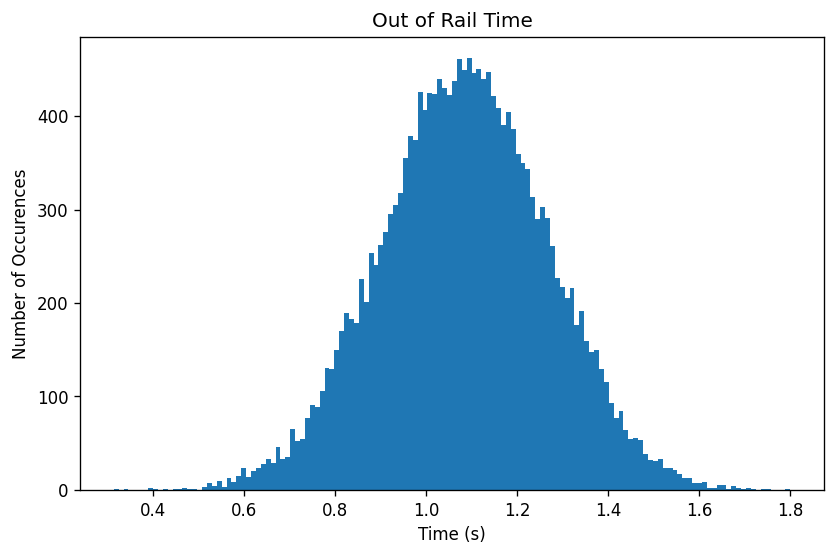

In [ ]:
print('Out of Rail Time - Mean Value: ', np.mean(dispersion_results["outOfRailTime"]))
print('Out of Rail Time - Standard Deviation: ', np.std(dispersion_results["outOfRailTime"]))
# dispersion_output_file.write ("outOfRailTime: " + str(np.mean(dispersion_results["outOfRailTime"])) +' | '+str(np.std(dispersion_results["outOfRailTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["outOfRailTime"], bins=int(N**0.5))
plt.title('Out of Rail Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Out of Rail Velocity

Out of Rail Velocity - Mean Value:  23.076550267849523
Out of Rail Velocity - Standard Deviation:  3.118005600978908


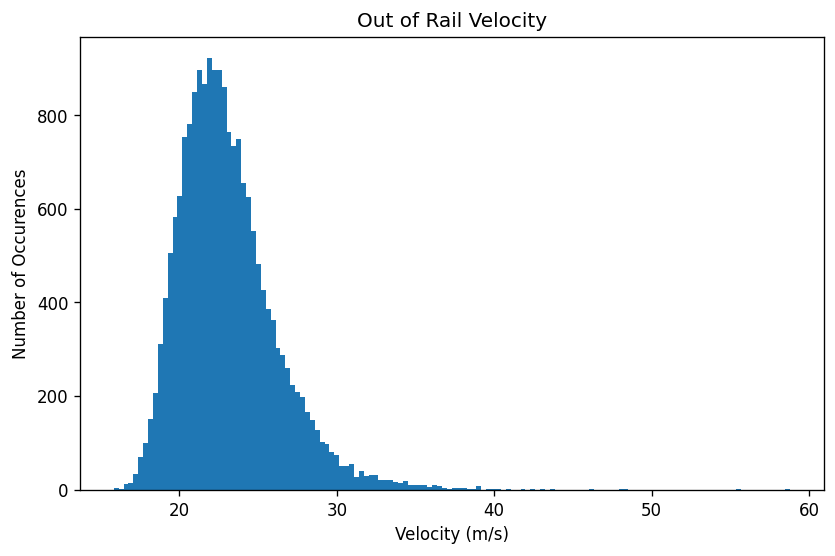

In [ ]:
print('Out of Rail Velocity - Mean Value: ', np.mean(dispersion_results["outOfRailVelocity"]))
print('Out of Rail Velocity - Standard Deviation: ', np.std(dispersion_results["outOfRailVelocity"]))
# dispersion_output_file.write ("outOfRailVelocity: " + str(np.mean(dispersion_results["outOfRailVelocity"])) +' | '+str(np.std(dispersion_results["outOfRailVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["outOfRailVelocity"], bins=int(N**0.5))
plt.title('Out of Rail Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Time

Apogee Time - Mean Value:  14.310798894057365
Apogee Time - Standard Deviation:  0.3546958639105797


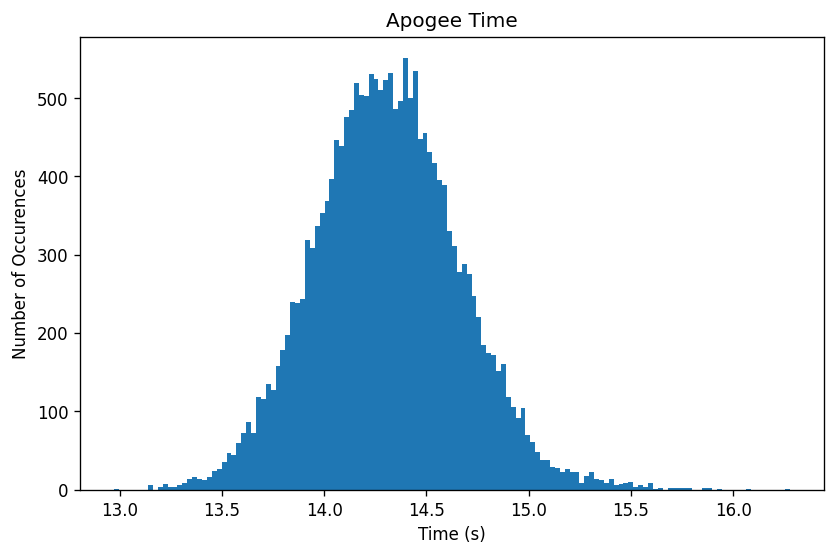

In [ ]:
print('Apogee Time - Mean Value: ', np.mean(dispersion_results["apogeeTime"]))
print('Apogee Time - Standard Deviation: ', np.std(dispersion_results["apogeeTime"]))
# dispersion_output_file.write ("apogeeTime: " + str(np.mean(dispersion_results["apogeeTime"])) +' | '+str(np.std(dispersion_results["apogeeTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeTime"], bins=int(N**0.5))
plt.title('Apogee Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Altitude

Apogee Altitude - Mean Value: 846.224
Apogee Altitude - Standard Deviation: 42.574


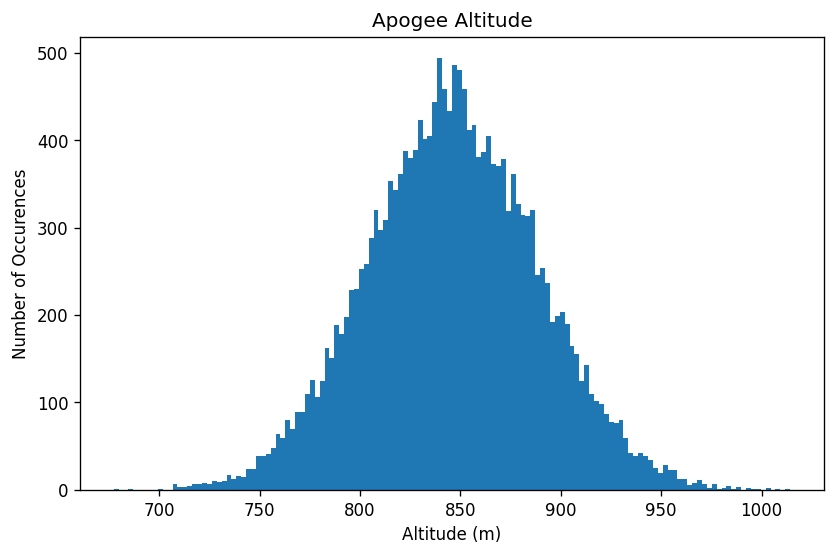

In [ ]:
print('Apogee Altitude - Mean Value: {:.3f}'.format(np.mean(dispersion_results["apogeeAltitude"])))
print('Apogee Altitude - Standard Deviation: {:.3f}'.format(np.std(dispersion_results["apogeeAltitude"])))
# dispersion_output_file.write ("apogeeAltitude: " + str(np.mean(dispersion_results["apogeeAltitude"])) +' | '+str(np.std(dispersion_results["apogeeAltitude"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title('Apogee Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Occurences')
plt.show()

# Real measured apogee = 860 m

### Apogee X Position

Apogee X Position - Mean Value:  105.86586186887851
Apogee X Position - Standard Deviation:  24.805453506079022


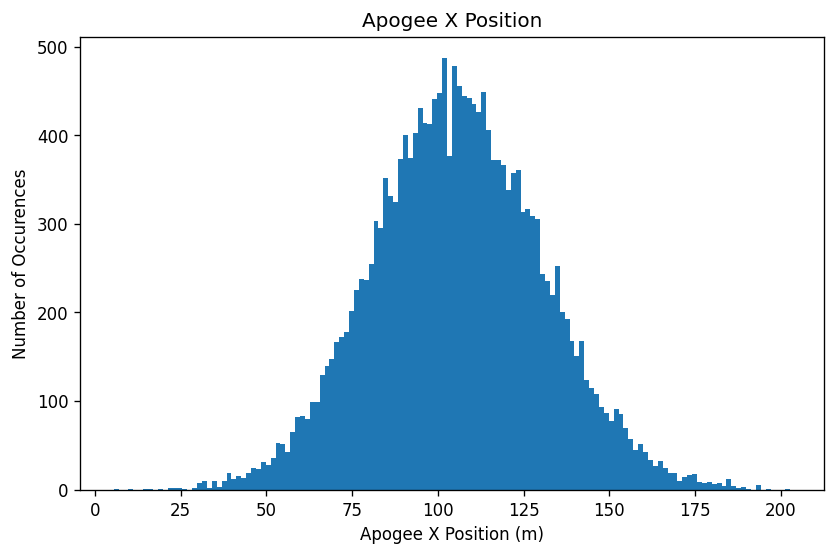

In [ ]:
print('Apogee X Position - Mean Value: ', np.mean(dispersion_results["apogeeX"]))
print('Apogee X Position - Standard Deviation: ', np.std(dispersion_results["apogeeX"]))
# dispersion_output_file.write ("apogeeX: " + str(np.mean(dispersion_results["apogeeX"])) +' | '+str(np.std(dispersion_results["apogeeX"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeX"], bins=int(N**0.5))
plt.title('Apogee X Position')
plt.xlabel('Apogee X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Y Position

Apogee Y Position - Mean Value:  108.85636590893517
Apogee Y Position - Standard Deviation:  19.76820574909656


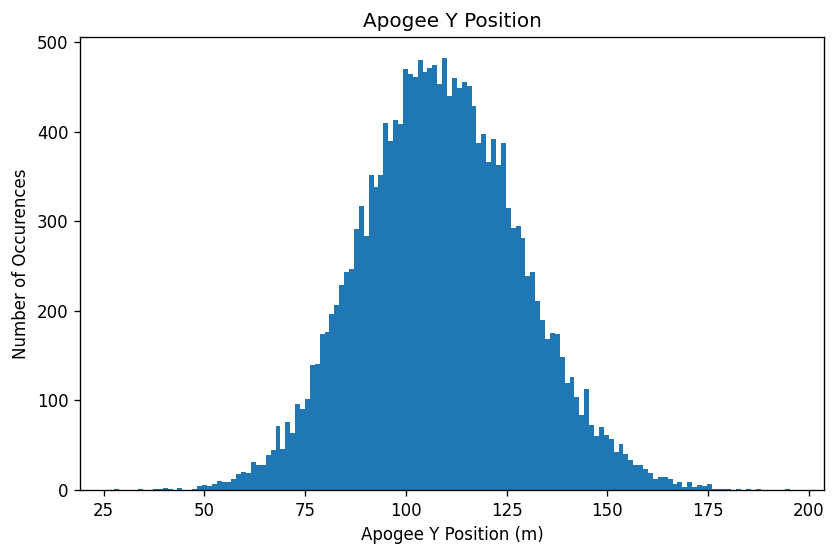

In [ ]:
print('Apogee Y Position - Mean Value: ', np.mean(dispersion_results["apogeeY"]))
print('Apogee Y Position - Standard Deviation: ', np.std(dispersion_results["apogeeY"]))
# dispersion_output_file.write ("apogeeY: " + str(np.mean(dispersion_results["apogeeY"])) +' | '+str(np.std(dispersion_results["apogeeY"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeY"], bins=int(N**0.5))
plt.title('Apogee Y Position')
plt.xlabel('Apogee Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Time

Impact Time - Mean Value:  62.95538847792596
Impact Time - Standard Deviation:  4.254638072499411


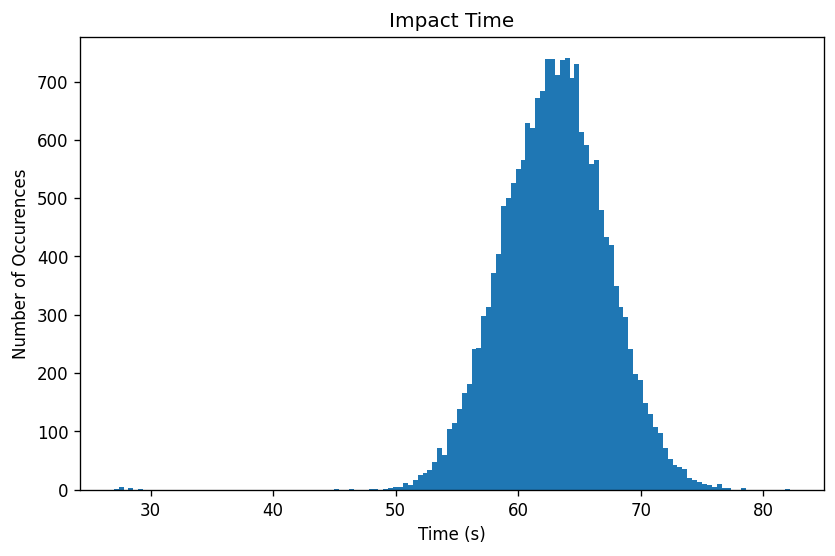

In [ ]:
print('Impact Time - Mean Value: ', np.mean(dispersion_results["impactTime"]))
print('Impact Time - Standard Deviation: ', np.std(dispersion_results["impactTime"]))
# dispersion_output_file.write ("impactTime: " + str(np.mean(dispersion_results["impactTime"])) +' | '+str(np.std(dispersion_results["impactTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactTime"], bins=int(N**0.5))
plt.title('Impact Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact X Position

Impact X Position - Mean Value:  387.41544148404876
Impact X Position - Standard Deviation:  48.22567804394269


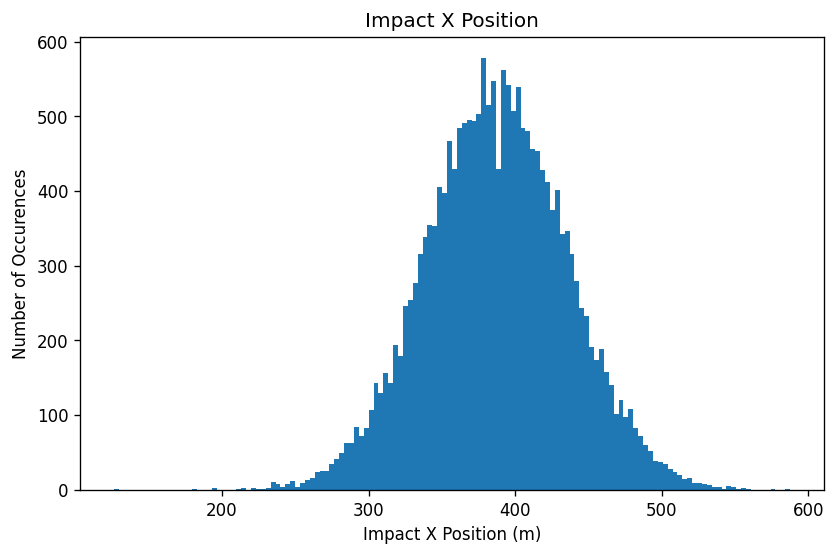

In [ ]:
print('Impact X Position - Mean Value: ', np.mean(dispersion_results["impactX"]))
print('Impact X Position - Standard Deviation: ', np.std(dispersion_results["impactX"]))
# dispersion_output_file.write ("impactX: " + str(np.mean(dispersion_results["impactX"])) +' | '+str(np.std(dispersion_results["impactX"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactX"], bins=int(N**0.5))
plt.title('Impact X Position')
plt.xlabel('Impact X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Y Position

Impact Y Position - Mean Value:  -0.21956565235608472
Impact Y Position - Standard Deviation:  38.15197587463702


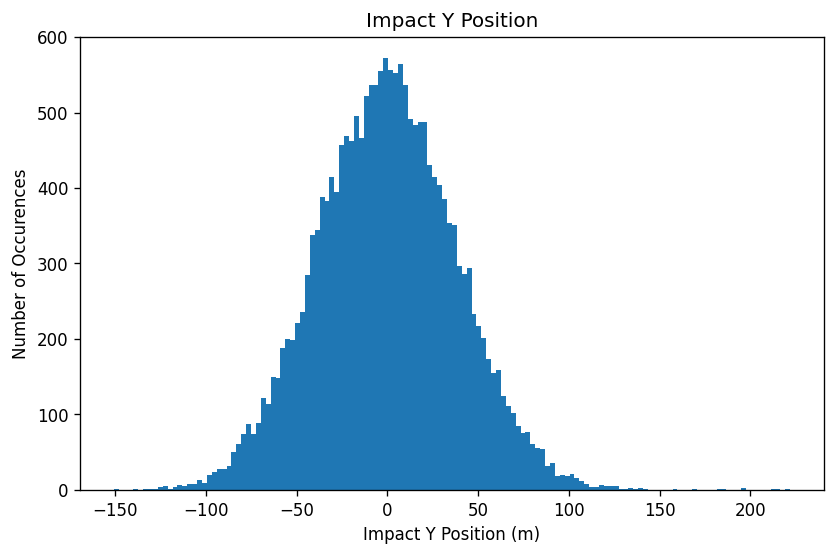

In [ ]:
print('Impact Y Position - Mean Value: ', np.mean(dispersion_results["impactY"]))
print('Impact Y Position - Standard Deviation: ', np.std(dispersion_results["impactY"]))
# dispersion_output_file.write ("impactY: " + str(np.mean(dispersion_results["impactY"])) +' | '+str(np.std(dispersion_results["impactY"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactY"], bins=int(N**0.5))
plt.title('Impact Y Position')
plt.xlabel('Impact Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Velocity

Impact Velocity- Mean Value:  -18.29687980681346
Impact Velocity - Standard Deviation:  2.519973751679567


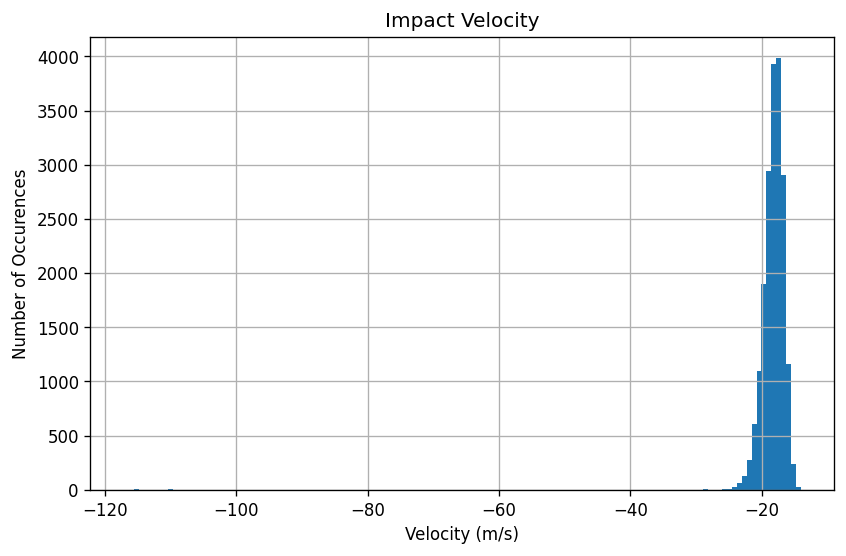

In [ ]:
print('Impact Velocity- Mean Value: ', np.mean(dispersion_results["impactVelocity"]))
print('Impact Velocity - Standard Deviation: ', np.std(dispersion_results["impactVelocity"]))
# dispersion_output_file.write ("impactVelocity: " + str(np.mean(dispersion_results["impactVelocity"])) +' | '+str(np.std(dispersion_results["impactVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactVelocity"], bins=int(N**0.5))
plt.title('Impact Velocity')
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Static Margin

Initial Static Margin - Mean Value:  2.0025342914885957
Initial Static Margin - Standard Deviation:  0.3250342737988034
Out of Rail Static Margin - Mean Value:  2.1831745213884797
Out of Rail Static Margin - Standard Deviation:  0.32840071985538377
Final Static Margin - Mean Value:  3.030823483750351
Final Static Margin - Standard Deviation:  0.3456696348006756


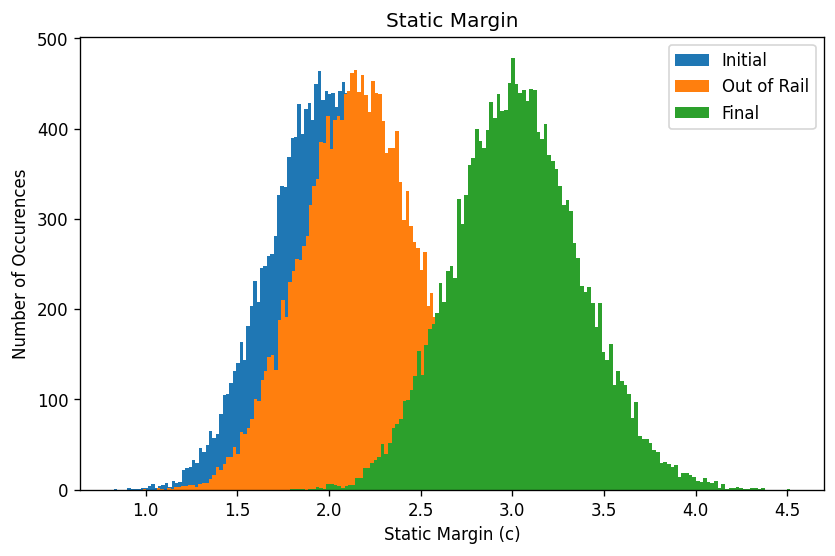

In [ ]:
print('Initial Static Margin - Mean Value: ', np.mean(dispersion_results["initialStaticMargin"]))
print('Initial Static Margin - Standard Deviation: ', np.std(dispersion_results["initialStaticMargin"]))
# dispersion_output_file.write ("initialStaticMargin: " + str(np.mean(dispersion_results["initialStaticMargin"])) +' | '+str(np.std(dispersion_results["initialStaticMargin"])) + "\n")
print('Out of Rail Static Margin - Mean Value: ', np.mean(dispersion_results["outOfRailStaticMargin"]))
print('Out of Rail Static Margin - Standard Deviation: ', np.std(dispersion_results["outOfRailStaticMargin"]))
# dispersion_output_file.write ("outOfRailStaticMargin: " + str(np.mean(dispersion_results["outOfRailStaticMargin"])) +' | '+str(np.std(dispersion_results["outOfRailStaticMargin"])) + "\n")
print('Final Static Margin - Mean Value: ', np.mean(dispersion_results["finalStaticMargin"]))
print('Final Static Margin - Standard Deviation: ', np.std(dispersion_results["finalStaticMargin"]))
# dispersion_output_file.write ("finalStaticMargin: " + str(np.mean(dispersion_results["finalStaticMargin"])) +' | '+str(np.std(dispersion_results["finalStaticMargin"])) + "\n")
plt.figure()
plt.hist(dispersion_results["initialStaticMargin"], label='Initial', bins=int(N**0.5))
plt.hist(dispersion_results["outOfRailStaticMargin"], label='Out of Rail', bins=int(N**0.5))
plt.hist(dispersion_results["finalStaticMargin"], label='Final', bins=int(N**0.5))
plt.legend()
plt.title('Static Margin')
plt.xlabel('Static Margin (c)')
plt.ylabel('Number of Occurences')
plt.show()

### Maximum Velocity

Maximum Velocity- Mean Value:  124.7804902733642
Maximum Velocity - Standard Deviation:  5.73372555425355


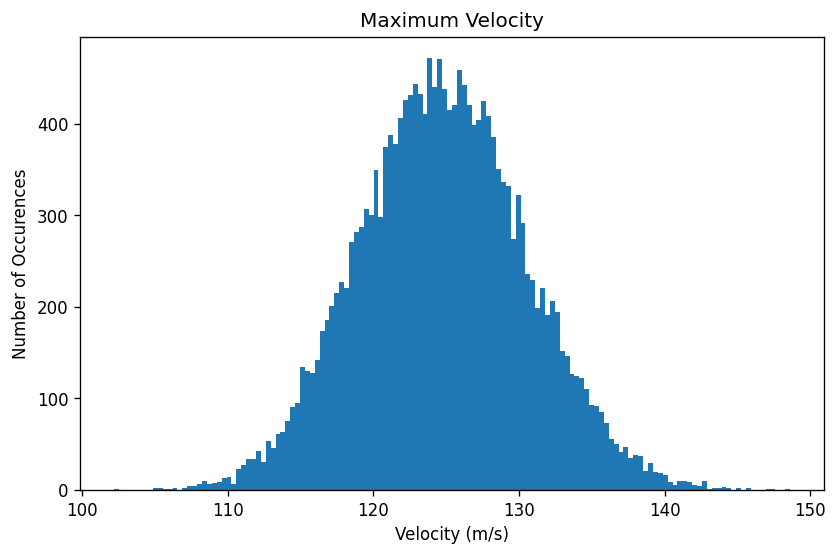

In [ ]:
print('Maximum Velocity- Mean Value: ', np.mean(dispersion_results["maxVelocity"]))
print('Maximum Velocity - Standard Deviation: ', np.std(dispersion_results["maxVelocity"]))
# dispersion_output_file.write("maxVelocity: " + str(np.mean(dispersion_results["maxVelocity"])) +' | '+str(np.std(dispersion_results["maxVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["maxVelocity"], bins=int(N**0.5))
plt.title('Maximum Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Parachute Events

Parachute Events - Mean Value:  1.0
Parachute Events - Standard Deviation:  0.0


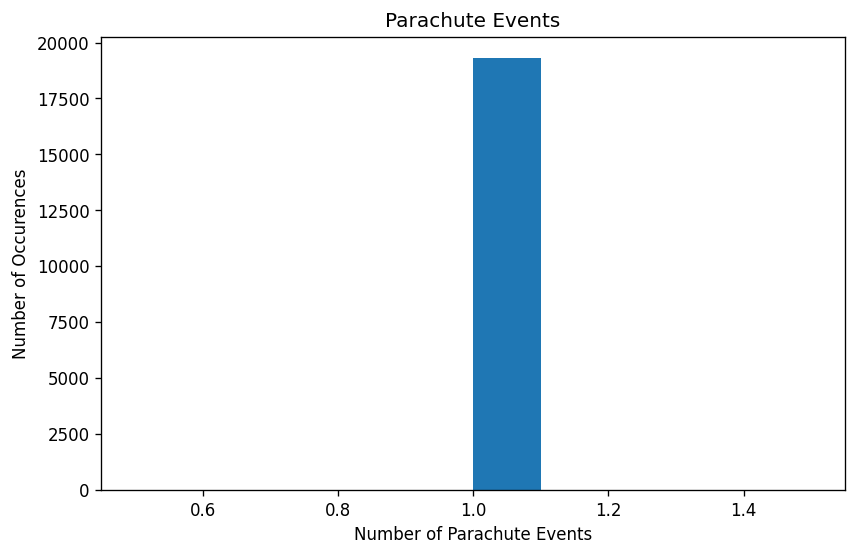

In [ ]:
print('Parachute Events - Mean Value: ', np.mean(dispersion_results["numberOfEvents"]))
print('Parachute Events - Standard Deviation: ', np.std(dispersion_results["numberOfEvents"]))
# dispersion_output_file.write ("numberOfEvents: " + str(np.mean(dispersion_results["numberOfEvents"])) +' | '+str(np.std(dispersion_results["numberOfEvents"])) + "\n")
plt.figure()
plt.hist(dispersion_results["numberOfEvents"])
plt.title('Parachute Events')
plt.xlabel('Number of Parachute Events')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Trigger Time

Drogue Parachute Trigger Time - Mean Value:  13.33126523562793
Drogue Parachute Trigger Time - Standard Deviation:  0.34323804076606235


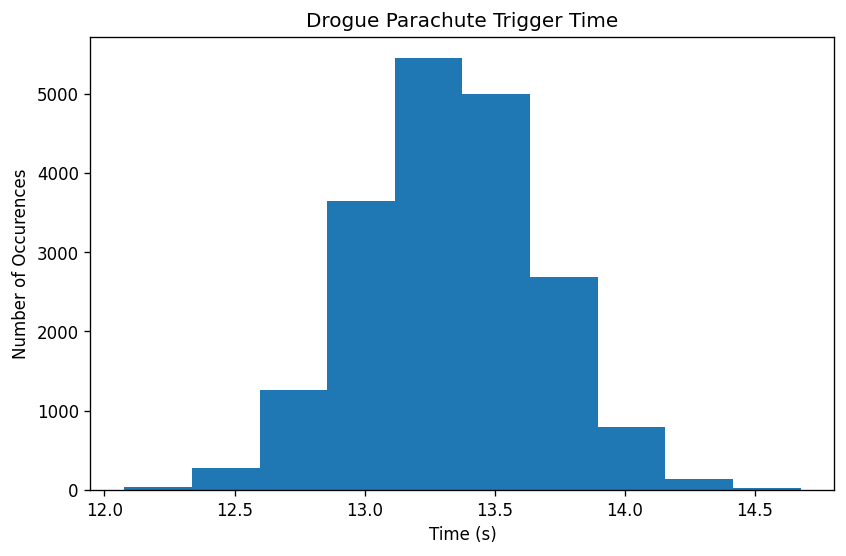

In [ ]:
print('Drogue Parachute Trigger Time - Mean Value: ', np.mean(dispersion_results["drogueTriggerTime"]))
print('Drogue Parachute Trigger Time - Standard Deviation: ', np.std(dispersion_results["drogueTriggerTime"]))
# dispersion_output_file.write ("drogueTriggerTime: " + str(np.mean(dispersion_results["drogueTriggerTime"])) +' | '+str(np.std(dispersion_results["drogueTriggerTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueTriggerTime"])
plt.title('Drogue Parachute Trigger Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Time

Drogue Parachute Fully Inflated Time - Mean Value:  15.067617484364476
Drogue Parachute Fully Inflated Time - Standard Deviation:  0.6260090819513968


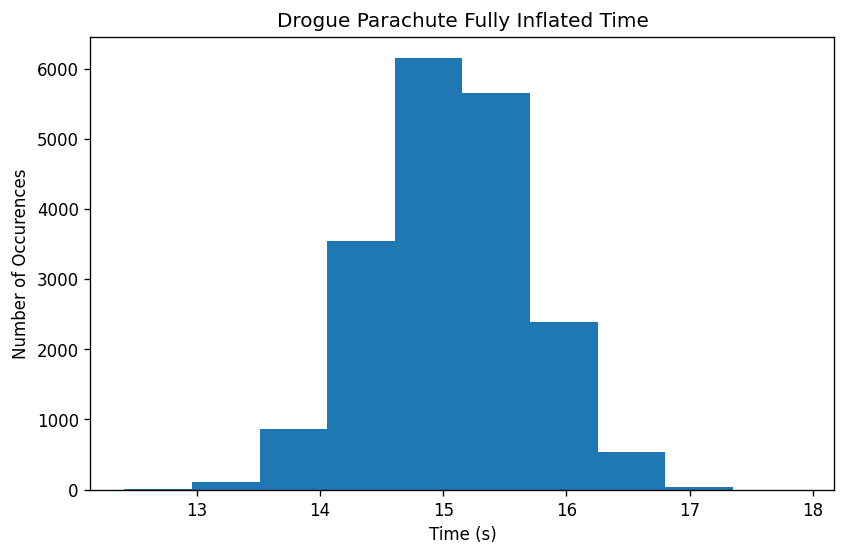

In [ ]:
print('Drogue Parachute Fully Inflated Time - Mean Value: ', np.mean(dispersion_results["drogueInflatedTime"]))
print('Drogue Parachute Fully Inflated Time - Standard Deviation: ', np.std(dispersion_results["drogueInflatedTime"]))
# dispersion_output_file.write ("drogueInflatedTime: " + str(np.mean(dispersion_results["drogueInflatedTime"])) +' | '+str(np.std(dispersion_results["drogueInflatedTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueInflatedTime"])
plt.title('Drogue Parachute Fully Inflated Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Velocity

Drogue Parachute Fully Inflated Velocity - Mean Value:  13.819418139494383
Drogue Parachute Fully Inflated Velocity - Standard Deviation:  3.0841368659087074


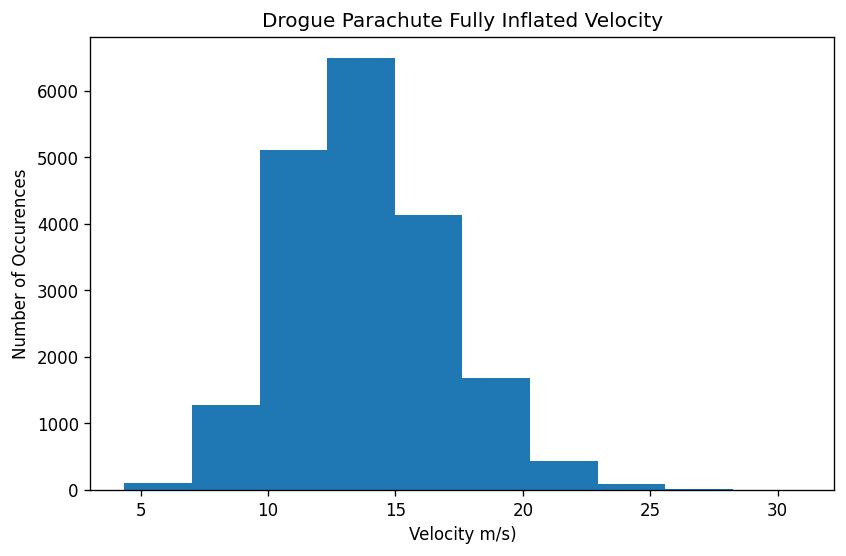

In [ ]:
print('Drogue Parachute Fully Inflated Velocity - Mean Value: ', np.mean(dispersion_results["drogueInflatedVelocity"]))
print('Drogue Parachute Fully Inflated Velocity - Standard Deviation: ', np.std(dispersion_results["drogueInflatedVelocity"]))
# dispersion_output_file.write ("drogueInflatedVelocity: " + str(np.mean(dispersion_results["drogueInflatedVelocity"])) +' | '+str(np.std(dispersion_results["drogueInflatedVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueInflatedVelocity"])
plt.title('Drogue Parachute Fully Inflated Velocity')
plt.xlabel('Velocity m/s)')
plt.ylabel('Number of Occurences')
plt.show()

In [ ]:
dispersion_output_file.close()

### Mean and Standard Deviation Variation with Number of Simulations

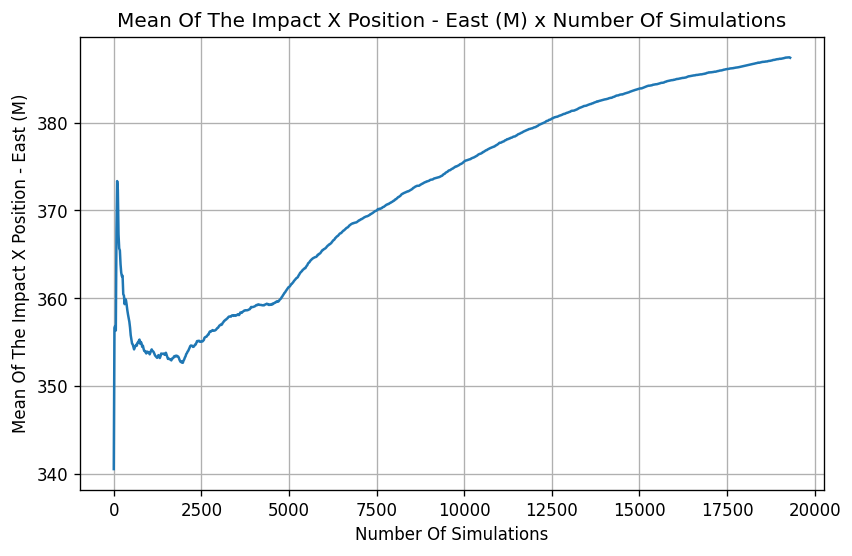

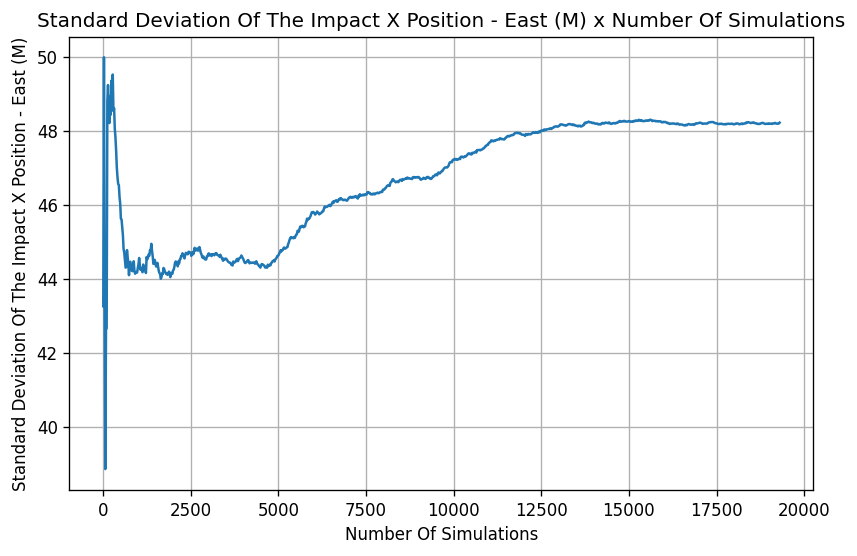

In [ ]:
mean = Function(lambda x: np.mean(dispersion_results["impactX"][0:int(x)]))
mean.setInputs('Number of Simulations')
mean.setOutputs('Mean of the Impact X Position - East (m)')
mean.plot(2, len(dispersion_results["impactX"]))

std = Function(lambda x: np.std(dispersion_results["impactX"][0:int(x)]))
std.setInputs('Number of Simulations')
std.setOutputs('Standard Deviation of the Impact X Position - East (m)')
std.plot(2, len(dispersion_results["impactX"]))

### Confidence interval of 99%

In [ ]:
N = len(dispersion_general_results)
print(2.576*np.std(dispersion_results["impactX"])/(N)**0.5)

0.8942224041755259


### Error Ellipses


Probability of Impact out of Error Ellipses: 1.047 %


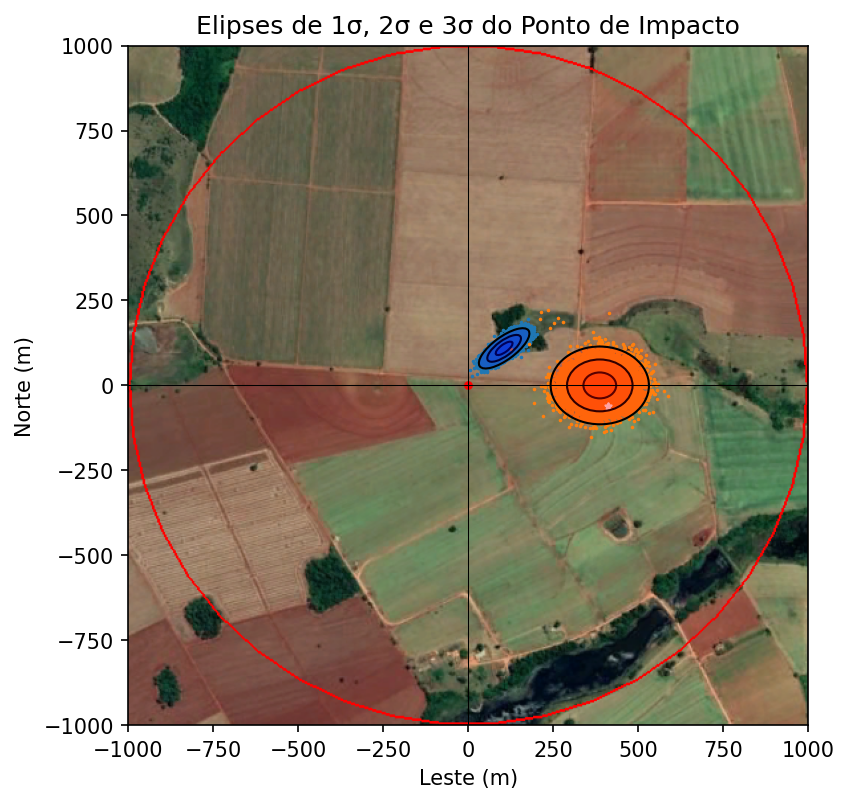

In [ ]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("Valetudo_basemap_final.png")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
  
# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='black')
    impactEll.set_facecolor((1, 0, 0, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
                  width=apogeeW*j, height=apogeeH*j,
                  angle=apogeeTheta, color='black')
    apogeeEll.set_facecolor((0, 0, 1, 0.2))
    ax.add_artist(apogeeEll)
    

# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=0.5)
    
# Draw impact points
plt.scatter(impactX, impactY, s=0.5)

# Draw launch point
plt.scatter(0, 0, s=10, color='red')

# Add title and labels to plot
ax.set_title('Elipses de 1σ, 2σ e 3σ do Ponto de Impacto')
ax.set_ylabel('Norte (m)')
ax.set_xlabel('Leste (m)')

# Add background image to plot
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1000-dx, 1000-dx, -1000-dy, 1000-dy])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Add real landing point
plt.scatter( 411.89, -61.07, s=10, color='white', marker='*')

# Calculate probability of rocket being out of 3-sigma error ellipse for impact
cos_angle = np.cos(np.radians(180.-impactTheta))
sin_angle = np.sin(np.radians(180.-impactTheta))

xc = impactX - np.mean(impactX)
yc = impactY - np.mean(impactY)

xct = xc * cos_angle - yc * sin_angle
yct = xc * sin_angle + yc * cos_angle 

n=3
rad_cc = (xct**2/(n*impactW/2.)**2) + (yct**2/(n*impactH/2.)**2)

colors_array = []
count = 0

for r in rad_cc:
    if r <= 1.:
        # point in ellipse
        colors_array.append('red')
        count+=1
    else:
        # point not in ellipse
        colors_array.append('blue')
        
print("Probability of Impact out of Error Ellipses: " + "{:.3f}".format(100 - 100*count/len(impactX)) + " %")
plt.savefig (str(filename)+ '.png')
plt.show()

### LASC MAP

Probability of Impact out of Error Ellipses: 1.047 %


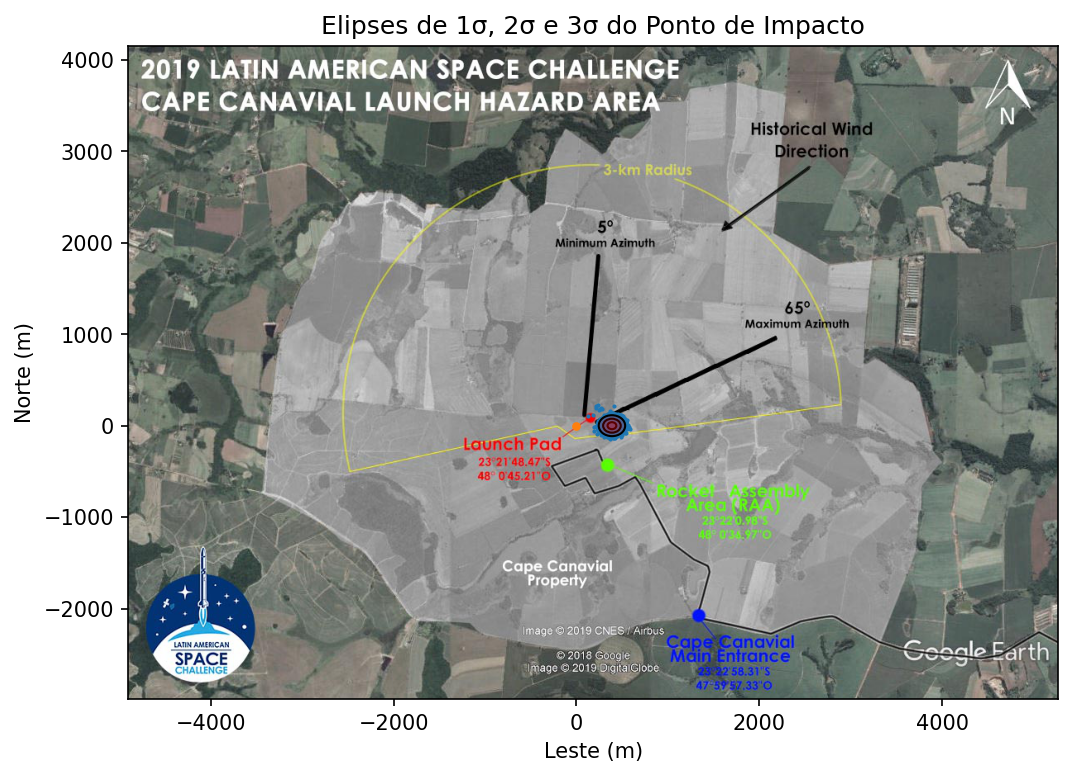

In [ ]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("LASC map.jpg")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
  
# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='black')
    impactEll.set_facecolor((1, 0, 0, 0.2))
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
                  width=apogeeW*j, height=apogeeH*j,
                  angle=apogeeTheta, color='black')
    apogeeEll.set_facecolor((0, 0, 1, 0.2))
    # ax.add_artist(apogeeEll)
    

# Draw apogee points
# plt.scatter(apogeeX, apogeeY, s=1)
    
# Draw impact points
plt.scatter(impactX, impactY, s=1)

# Draw launch point
plt.scatter(0, 0, s=10)

# Add title and labels to plot
ax.set_title('Elipses de 1σ, 2σ e 3σ do Ponto de Impacto')
ax.set_ylabel('Norte (m)')
ax.set_xlabel('Leste (m)')

# Add background image to plot
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-4900-dx, 5270-dx, -2990-dy, 4150-dy])

# Save background image
# plt.savefig('euporia2-1.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Calculate probability of rocket being out of 3-sigma error ellipse for impact
cos_angle = np.cos(np.radians(180.-impactTheta))
sin_angle = np.sin(np.radians(180.-impactTheta))

xc = impactX - np.mean(impactX)
yc = impactY - np.mean(impactY)

xct = xc * cos_angle - yc * sin_angle
yct = xc * sin_angle + yc * cos_angle 

n=3
rad_cc = (xct**2/(n*impactW/2.)**2) + (yct**2/(n*impactH/2.)**2)

colors_array = []
count = 0

for r in rad_cc:
    if r <= 1.:
        # point in ellipse
        colors_array.append('red')
        count+=1
    else:
        # point not in ellipse
        colors_array.append('blue')
        
print("Probability of Impact out of Error Ellipses: " + "{:.3f}".format(100 - 100*count/len(impactX)) + " %")
plt.savefig (str(filename)+ '.png')
plt.show()